In [1]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

/tmp/ipykernel_91568/2373981694.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('dataset.csv')

categorical_features_indices = ['region_id', 'city_id', 'slider', 'position_type']

for feature in categorical_features_indices:
    df[feature] = df[feature].astype('category')

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
model = CatBoostClassifier(iterations=1_000,
                           learning_rate=0.2,
                           depth=6,
                           silent=True,
                           task_type="GPU",
                           devices='0',
                           cat_features=categorical_features_indices)

model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [4]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f'F1-Score: {f1}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')

F1-Score: 0.7811512587911528
Recall: 0.7632011352602883
Accuracy: 0.7862307567856832


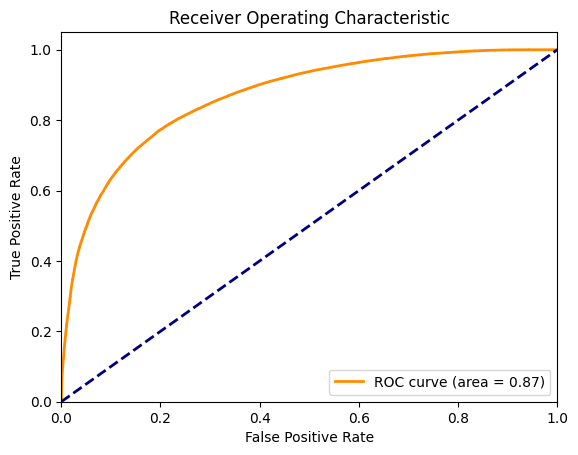

In [5]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

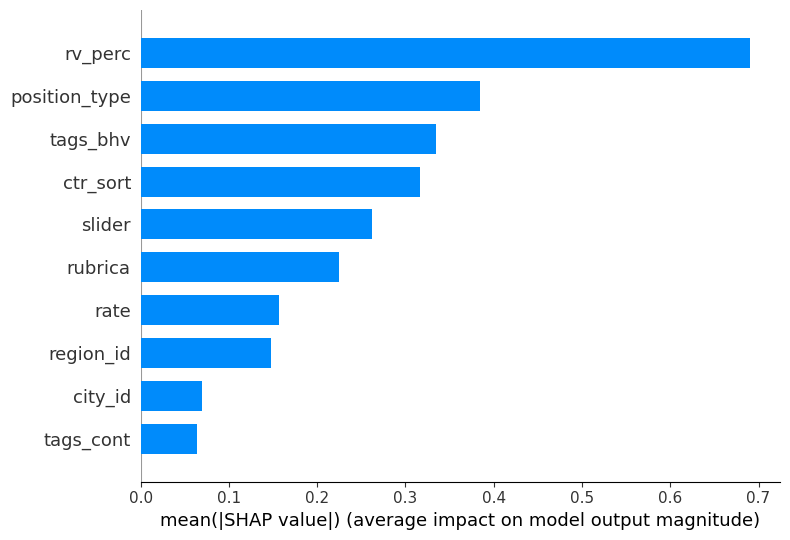

In [8]:
import shap

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(Pool(X_test, cat_features=categorical_features_indices))

shap.summary_plot(shap_values, X_test, plot_type="bar")